# Composite Indicator

In [338]:
#importing libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
import warnings
warnings.filterwarnings('ignore')

%load_ext extensions.skip

# defining a style
sns.set(style='darkgrid')
colors_arr = ['#1a96d0', '#fe9c39']

The extensions.skip extension is already loaded. To reload it, use:
  %reload_ext extensions.skip


In [162]:
# choose the spatial unit: neighborhood or hdu
spatial_unit = 'hdu'

spatial_area_label = 'hdu_id' if spatial_unit == 'hdu' else 'neighborhood'

## 1. Loading the data

This provided dataset is the one obtained after the data cleaning stage mentioned in the article *"A composite indicator of liveability based on sociodemographic and Uber quality service dimensions: a data-driven approach"*.

In [163]:
df = pd.read_csv("./data/uber_{}.csv".format(spatial_unit), index_col=0)

In [164]:
df[spatial_area_label] = df[spatial_area_label].astype(str)

### 1.1. Preparing the data

In [165]:
# adding new variables
if spatial_unit == 'neighborhood':
  df['car_crimes_rate'] = 100000*(df['car_theft'] + df['car_robbery'])/df['population']
  df['urban_services_ratio'] = 100000*(df['education_units'] + df['health_units'] + df['security_units'])/df['population']

In [166]:
numeric_cols = list(df.select_dtypes(['float64', 'int64']).columns)

# Selecting numeric columns and standardizing the variables
numerical_data = df[numeric_cols]
scaler = StandardScaler()
# data have to be standardized, once this is a requirement to run FA
numerical_data = scaler.fit_transform(numerical_data)

df_numerical = pd.DataFrame(numerical_data, columns = numeric_cols)
df_numerical.shape

(58, 15)

## 2. Composite Indicator of Liveability (CIL)

### 2.1. Factor Analysis (FA)

#### 2.1.1. Checking correlations


**CORRELATIONS**

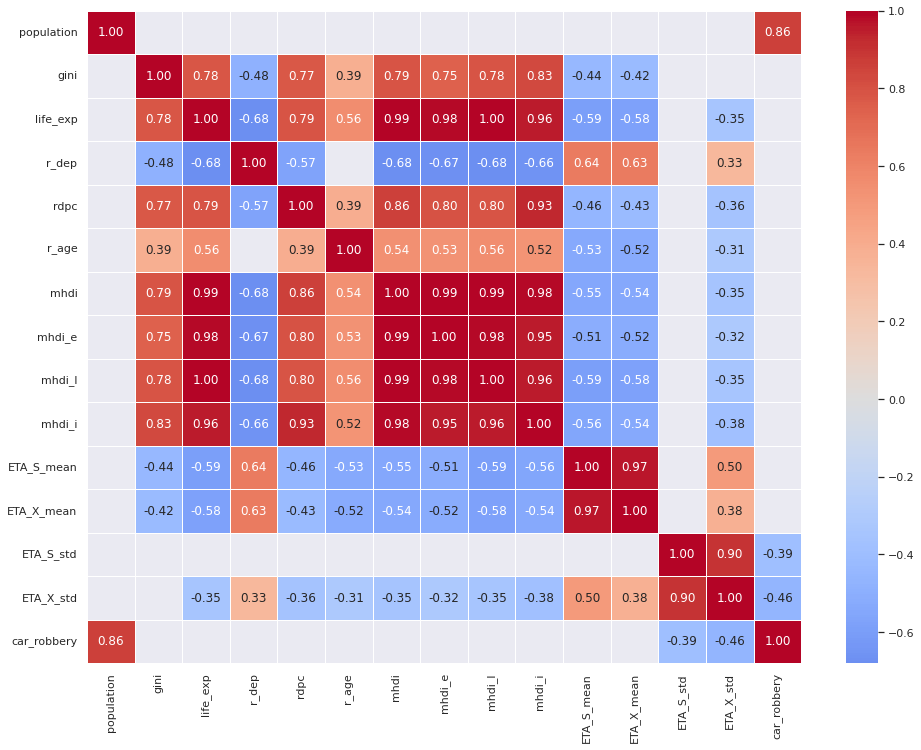

In [167]:
corr = df_numerical.corr()
fig, ax = plt.subplots(figsize=(16,12))

# Hiding the correlations that are smaller than 0.3
sns.heatmap(corr, mask = corr.abs() < 0.3, cmap="coolwarm", center=0, annot=True, fmt=".2f", linewidths=.5, ax=ax)
bottom, top = ax.get_ylim()

In [168]:
(corr.abs() < 0.3).sum().sum()/corr.shape[0]**2

0.3288888888888889

Initially, the Factor Analysis (FA) was undertaken considering neighborhood as unit of analysis. However, this dataset did not meet the suitability criteria for the FA implementation, mainly because its variables are mostly weakly correlated (about **57%** of the correlogram coefficients were less than 0.3 and more than **76%** were less than 0.5).  Consequently, it was not feasible to implement the indicator for this spatial aggregation level.

In the case of intra-neighborhood (HDU), three variables (population, car_robbery, ETA_S_std) with the highest amount of weak correlations had to be eliminated so that all the FA suitability criteria could be met.

In [169]:
# As the strong correlations were found only in the HDU dataset, we can skip the following steps for the neighborhood dataset
skip_cell = spatial_unit == 'neighborhood'

In [170]:
%%skip $skip_cell

df_numerical = df_numerical.drop(['population', 'car_robbery', 'ETA_S_std'], axis=1)

# checking the ratio of correlation values that are smaller than 0.3
corr = df_numerical.corr()
print((corr.abs() < 0.3).sum().sum()/corr.shape[0]**2)

0.027777777777777776


#### 2.1.2. suitability criteria

**STATISTICAL TESTS**

**Bartlett’s test** of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, you should not employ factor analysis.

**Kaiser-Meyer-Olkin (KMO) test** measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variables and ranges between 0 and 1. In general, a KMO < 0.6 is considered inadequate.

In [294]:
def isSuitableForFA(df):
  chisquare, pvalue_bartlett = calculate_bartlett_sphericity(df)
  _, kmo_total = calculate_kmo(df)
  
  print('Check suitability')
  print('- Chi-square statistic is {:.4f}, with p-value {}'.format(chisquare, pvalue_bartlett))
  print('- Total KMO is {:.4f}'.format(kmo_total))

  # checks if Bartlett's test is significant (< 0.05) and the total KMO is at least 0.6 (>= 0.6).
  return pvalue_bartlett < 0.05 and kmo_total >= 0.6

#### 2.1.3. Factor Extraction using Principal Component Analysis (PCA) and factor rotation

In [342]:
def getNumberOfFactors(df: pd.DataFrame):
  fa = FactorAnalyzer(n_factors=df.shape[1], method='principal', rotation=None)
  fa.fit(df)

  eingvalues, _ = fa.get_eigenvalues()
  _, prop_variance, cum_variance = fa.get_factor_variance()
  n_factors = np.sum((eingvalues > 1) & (prop_variance > 0.1))

  print('Number of factors: ', n_factors)
  print('- Proportion of variance explained by the {} factor(s): '.format(n_factors), prop_variance[:n_factors])
  print('- Proportion of cumulative variance of {} factor(s): '.format(n_factors), cum_variance[n_factors - 1])
  plotFactorExtraction(df, eingvalues, prop_variance, cum_variance)

  return n_factors

def plotFactorExtraction(df, eingvalues, prop_variance, cum_variance, i = 1):
  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
  axs[0].scatter(range(1, df.shape[1]+1), eingvalues)
  axs[0].plot(range(1, df.shape[1]+1), eingvalues)
  axs[0].plot(range(1, df.shape[1]+1), [1] * df.shape[1], '--', linewidth=1.5, color="red")
  axs[0].set_xlabel('Factors')
  axs[0].set_ylabel('Eingvalues')

  axs[1].bar(range(1, len(prop_variance) + 1), prop_variance)
  axs[1].set_xlabel('Number of components')
  axs[1].set_ylabel('Proportion of explained variance (%)');

  axs[2].plot(range(1, len(prop_variance) + 1), cum_variance)
  axs[2].scatter(range(1, len(prop_variance) + 1), cum_variance)
  axs[2].set_xlabel('Number of components')
  axs[2].set_ylabel('Proportion of cumulative variance (%)')
  plt.show()

In [ ]:
def checkFeaturesCommunalitiesForRemoval(fa: FactorAnalyzer, features, threshold = 0.5):
  communalities = fa.get_communalities()
  # return non-ideal features that should be removed
  return features[communalities < threshold]

def checkFeaturesLoadingsForRemoval(fa: FactorAnalyzer, features, threshold = 0.4):
  cols_to_drop = []
  for i, loading in enumerate(fa.loadings_):
    if abs(loading[0]) > threshold and abs(loading[1]) > threshold:
      cols_to_drop.append(features[i])
  return cols_to_drop

In [353]:
def performFactorAnalysis(df, i = 1):
  print('ITERATION #{}'.format(i))
  
  if (isSuitableForFA(df)):
    n_factors = getNumberOfFactors(df)

    fa = FactorAnalyzer(n_factors=n_factors, method='principal', rotation='varimax')
    fa.fit(df)

    cols_to_drop = checkFeaturesCommunalitiesForRemoval(fa, df.columns)
    if len(cols_to_drop) > 0:
      return performFactorAnalysis(df.drop(columns=cols_to_drop, axis=1), i + 1)
    else:
      cols_to_drop = checkFeaturesLoadingsForRemoval(fa, df.columns)
      if len(cols_to_drop) > 0:
        return performFactorAnalysis(df.drop(columns=cols_to_drop, axis=1), i + 1)
      printFactors(fa, df.columns, n_factors)
      return fa, df.columns, n_factors

def printFactors(fa, features, n_factors):
  cols = ['Factor ' + str(i + 1) for i in range(n_factors)]
  factors_df = pd.DataFrame(np.copy(fa.loadings_), columns=cols, index=features)
  print(factors_df)

ITERATION #1
Check suitability
- Chi-square statistic is 2082.2473, with p-value 0.0
- Total KMO is 0.7618
Number of factors:  2
- Proportion of variance explained by the 2 factor(s):  [0.67950291 0.12000813]
- Proportion of cumulative variance of 2 factor(s):  0.799511038111479


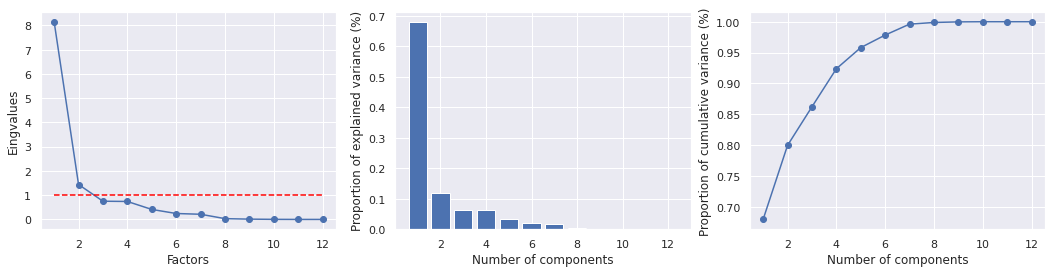

ITERATION #2
Check suitability
- Chi-square statistic is 2032.5848, with p-value 0.0
- Total KMO is 0.7581
Number of factors:  2
- Proportion of variance explained by the 2 factor(s):  [0.76326504 0.13017519]
- Proportion of cumulative variance of 2 factor(s):  0.8934402312773262


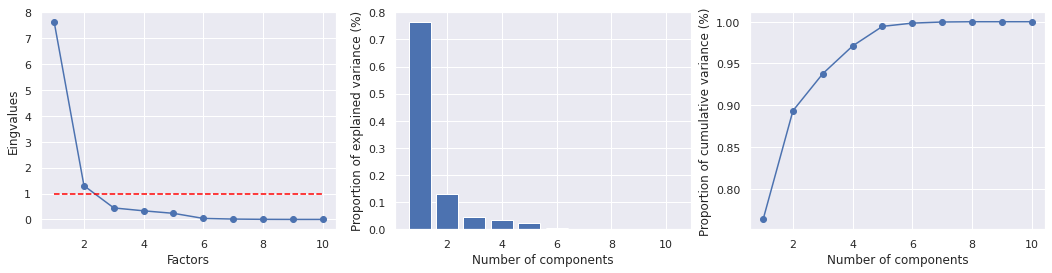

ITERATION #3
Check suitability
- Chi-square statistic is 1997.4026, with p-value 0.0
- Total KMO is 0.7284
Number of factors:  2
- Proportion of variance explained by the 2 factor(s):  [0.7881781 0.1372505]
- Proportion of cumulative variance of 2 factor(s):  0.9254285958368317


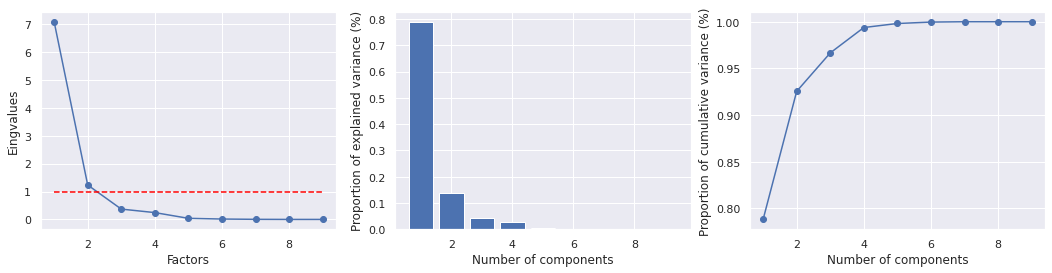

            Factor 1  Factor 2
gini        0.836155  0.185948
life_exp    0.917014  0.344599
rdpc        0.877399  0.184474
mhdi        0.947825  0.293080
mhdi_e      0.931359  0.269246
mhdi_l      0.917352  0.345173
mhdi_i      0.950045  0.284701
ETA_S_mean -0.295770 -0.945042
ETA_X_mean -0.279513 -0.950990


In [354]:
fa, features, n_factors = performFactorAnalysis(df_numerical)

#### 2.1.4. Visualizing results